## Predictive Analytics-Sentiment Prediction

In [ ]:
#The problem statement is to predict the sentiment of the comments i.e positive/negative/neutral. 
#Machine learning classification model is built for this purpose

In [1]:
#Packages are imported
import pandas as pd
import numpy as np
import unicodedata  
from nltk import sent_tokenize
from nltk.corpus import stopwords
import nltk
import re
import contractions 
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

## Load the data

In [2]:
#Reading the file
data = pd.read_csv('comments.csv', index_col=0)
data.columns = [x.upper() for x in data.columns]

In [3]:
#Checking missing values
data.isna().sum()

VIDEO ID     0
COMMENT      1
LIKES        0
SENTIMENT    0
dtype: int64

Only one missing value in comment removing that record

In [4]:
data.dropna(inplace=True)

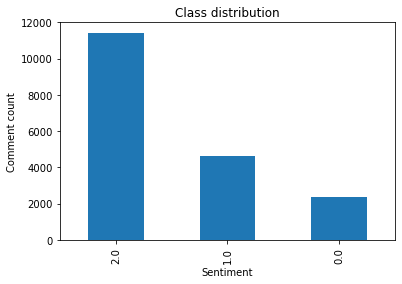

In [5]:
#Plotting comment distribution for positive/neutral/negative comments
data['SENTIMENT'].value_counts().plot(kind='bar')
plt.title('Class distribution')
plt.xticks([2,1,0])
plt.ylabel('Comment count')
plt.xlabel('Sentiment')
plt.show()

In [6]:
data['SENTIMENT'].value_counts(), data.shape

(2.0    11432
 1.0     4638
 0.0     2338
 Name: SENTIMENT, dtype: int64,
 (18408, 4))

In [7]:
data.groupby(['SENTIMENT']).agg({'LIKES':['mean','median']})

LIKES       
                  mean median
SENTIMENT                    
0.0        1821.266039   65.0
1.0        1085.954291   26.0
2.0         861.698828   26.0

## Preprocessing the data

In [8]:
# The comments are pre-processed
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)


def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        new_word = re.sub(r'(.)\1+', r'\1\1', new_word) 
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    sw = stopwords.words('english')
    for word in words:
        if word not in sw:
            new_words.append(word)
    return new_words

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

In [9]:
def preprocess(text):
    # removing urls
    text = re.sub(r'https?://\S+',' ',text)
    # replace contractions
    text = replace_contractions(text)
    # tokenise the text
    content = nltk.word_tokenize(text)
    # remove non ascii words
    words = remove_non_ascii(content)
    # lower case words
    words = to_lowercase(words)
    # remove stopwords
    words = remove_stopwords(words)
    # lemmatise words
    words = lemmatize_verbs(words)
    # remove puncs
    words = remove_punctuation(words)
    # restore text to sentence
    text = ' '.join(words)
    return text

def join_tags(words):
  text = ''.join(words)
  return text

In [10]:
#Pre-processing the comments
data['NEW_COMMENT'] = data['COMMENT'].apply(preprocess)

In [11]:
#Displaying comments after pre-processing
data.head()

,VIDEO ID,COMMENT,LIKES,SENTIMENT,NEW_COMMENT
0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95.0,1.0,let us forget apple pay 2014 require brand new...
1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19.0,0.0,nz 50 retailers even contactless credit card m...
2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161.0,2.0,forever acknowledge channel help lessons ideas...
3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8.0,0.0,whenever go place take apple pay happen often ...
4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34.0,2.0,apple pay convenient secure easy use use korea...


## Splitting the dataset


In [12]:
# train, test = train_test_split(data, random_state=0, test_size=0.25, stratify=data['SENTIMENT'], shuffle=True)
# train.shape, test.shape


### same training and testing data as used in xlnet problem

train1 = pd.read_csv('train-2.csv')
train1.columns= ['INDEX','NEW_COMMENT','SENTIMENT']

test1 = pd.read_csv('test-2.csv')
test1.columns= ['INDEX','NEW_COMMENT','SENTIMENT']


train = data.loc[train1['INDEX']]
test = data.loc[test1['INDEX']]

In [13]:
train.head()

,VIDEO ID,COMMENT,LIKES,SENTIMENT,NEW_COMMENT
9315,uCUge68Z228,I love 1 2 3 go they're so amazing and subscribe,0.0,2.0,love 1 2 3 go amaze subscribe
4074,Ycn6-ydiEeI,Go Ryden great work we LOVE this thanks for sh...,23.0,2.0,go ryden great work love thank share
6871,eREopphW5Bw,This is why I pretty much lost a significant f...,30.0,0.0,pretty much lose significant focus write criti...
872,iRxsHyRJnnQ,Halo mister coba besok mister main stumble guy...,2.0,2.0,halo mister coba besok mister main stumble guy...
565,OTFKyW-vc_Y,Which means the taxpayers will have to foot th...,139.0,0.0,mean taxpayers foot bill


In [14]:
test['SENTIMENT'].value_counts(normalize=True), train['SENTIMENT'].value_counts(normalize=True)

(2.0    0.621034
 1.0    0.251847
 0.0    0.127119
 Name: SENTIMENT, dtype: float64,
 2.0    0.621034
 1.0    0.251992
 0.0    0.126974
 Name: SENTIMENT, dtype: float64)

In [49]:
#CountVectorizer 
count_vec = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', \
                            ngram_range=(1,2), dtype=np.float32)
train_comment = count_vec.fit_transform(train['NEW_COMMENT'])
test_comment = count_vec.transform(test['NEW_COMMENT'])

In [15]:
#TF-IDF Vectorizer
tfidf = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}',\
                        ngram_range=(1,2), dtype=np.float32)
train_comment_tf = tfidf.fit_transform(train['NEW_COMMENT'])
test_comment_tf = tfidf.transform(test['NEW_COMMENT'])

In [16]:
y_train = train['SENTIMENT'].values
y_test = test['SENTIMENT'].values

## Create model

In [18]:
# Using differrent machine learning algorithms for model selection. The model with highest 'F1-Score' is selected
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from tqdm import tqdm

models = {'svm': SVC(class_weight = 'balanced', random_state=0),
        'lr': LogisticRegression(class_weight = 'balanced', random_state=0),
        'rf': RandomForestClassifier(class_weight='balanced', random_state=0),
        'lgbm': LGBMClassifier(is_unbalance=True, random_state=0, objective='multiclass'),
        'gbt': GradientBoostingClassifier(random_state=0),
        'xgb': XGBClassifier(objective='multi:softmax', 
                          num_class=3,eval_metric='aucpr', random_state=0),
#         'nb': GaussianNB(),
        'knn': KNeighborsClassifier()}

## Modelling with Countvectoriser

In [34]:

results = {}
for m in tqdm(models.keys()):
  model = models[m]
  model.fit(train_comment, y_train)
  pred = model.predict(test_comment)
  results[m] = f1_score(y_test, pred, average='macro')


100%|█████████████████████████████████████████████| 7/7 [02:10<00:00, 18.71s/it]


In [35]:
nb = GaussianNB()
nb.fit(train_comment.toarray(), y_train)
pred = nb.predict(test_comment.toarray())
results['nb'] = f1_score(y_test, pred, average='macro')

In [36]:
#The F1-Score of differrent model are displayed here
results

{'svm': 0.6410537939876049,
 'lr': 0.6699256318534745,
 'rf': 0.5269310812764684,
 'lgbm': 0.6436671390026047,
 'gbt': 0.4569085049622737,
 'xgb': 0.6264736600450661,
 'knn': 0.4301117549672775,
 'nb': 0.5130866365892315}

In [19]:
final_model = models['lr']
final_model.fit(train_comment, y_train)
pred = final_model.predict(test_comment)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.57      0.46      0.51       585
         1.0       0.59      0.70      0.64      1159
         2.0       0.88      0.84      0.86      2858

    accuracy                           0.76      4602
   macro avg       0.68      0.67      0.67      4602
weighted avg       0.77      0.76      0.76      4602

[[ 272  205  108]
 [ 123  813  223]
 [  84  369 2405]]


Count vectoriser results

## Modelling with TF IDF

Model Selection

In [93]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer


def f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')


cv_res = {}
for m in tqdm(models.keys()):
    model = models[m]
    skf = StratifiedKFold(n_splits=3,random_state=True, shuffle=True)
    scores = cross_val_score(model, train_comment_tf, y_train, cv=skf, scoring=make_scorer(f1))
    cv_res[m] = np.mean(scores)

100%|████████████████████████████████████████████| 7/7 [19:05<00:00, 163.59s/it]


In [95]:
nb = GaussianNB()
scores=cross_val_score(nb, train_comment_tf.toarray(), y_train, cv=skf, scoring=make_scorer(f1))
cv_res['nb']=np.mean(scores)

In [111]:

results1 = pd.DataFrame(cv_res.values(), index=cv_res.keys())

results1.sort_values(by=[0], inplace=True, ascending=False)

results1

,0
lr,0.657434
lgbm,0.626781
xgb,0.614093
svm,0.549255
rf,0.509188
nb,0.485326
gbt,0.447356
knn,0.186031


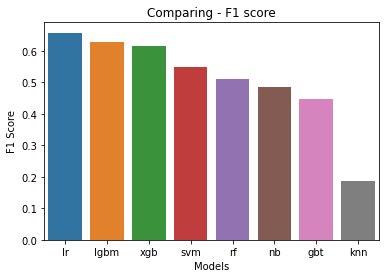

In [131]:
#Comparing the F1-score of differrent models
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(results1.index,results1[0])
plt.title('Comparing - F1 score')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.show()

In [19]:
%%time

#Logistic Regression model is selected because it has the highest F1-Score
#training the model
final_model = LogisticRegression(class_weight='balanced', C=0.4)
final_model.fit(train_comment_tf, y_train)


CPU times: user 16 s, sys: 3.81 s, total: 19.9 s
Wall time: 3.49 s


LogisticRegression(C=0.4, class_weight='balanced')

In [21]:
%%time
#predicting the comments on test set
pred = final_model.predict(test_comment_tf)
train_pred = final_model.predict(train_comment_tf)


CPU times: user 20 ms, sys: 13.5 ms, total: 33.5 ms
Wall time: 32 ms


In [22]:

#Classification report using Logistic Regression model on train and test set
print('Classification report on train set')
print(classification_report(y_train, train_pred))

print('Classification report on test set')
print(classification_report(y_test, pred))

test_cm = confusion_matrix(y_test, pred)
train_cm = confusion_matrix(y_train, train_pred)


Classification report on train set
              precision    recall  f1-score   support

         0.0       0.79      0.99      0.88      1753
         1.0       0.75      0.93      0.83      3479
         2.0       0.98      0.84      0.91      8574

    accuracy                           0.88     13806
   macro avg       0.84      0.92      0.87     13806
weighted avg       0.90      0.88      0.88     13806

Classification report on test set
              precision    recall  f1-score   support

         0.0       0.45      0.68      0.54       585
         1.0       0.62      0.60      0.61      1159
         2.0       0.89      0.81      0.84      2858

    accuracy                           0.74      4602
   macro avg       0.65      0.70      0.67      4602
weighted avg       0.76      0.74      0.75      4602



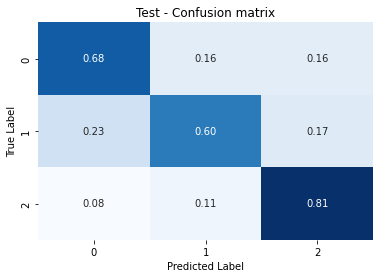

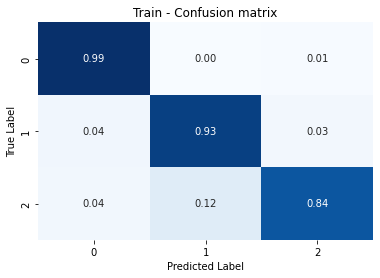

In [59]:
#Normalised Confusion Matrix using Logistic Regression model
norm_test_cm = test_cm/test_cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(norm_test_cm, annot=True, cmap='Blues', fmt='0.2f', cbar=False)
plt.title('Test - Confusion matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

norm_train_cm = train_cm/train_cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(norm_train_cm, annot=True, cmap='Blues', fmt='.2f', cbar=False)
plt.title('Train - Confusion matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Hyperparameter tuning

In [61]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

# define model
final_model = LogisticRegression()

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100] #loguniform(1e-5, 100)#[


# define search
search = GridSearchCV(final_model, space, scoring=make_scorer(f1), n_jobs=-1, cv=5)

# execute search
result = search.fit(train_comment_tf, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

## Word cloud

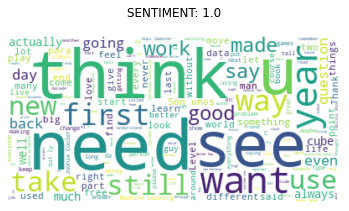

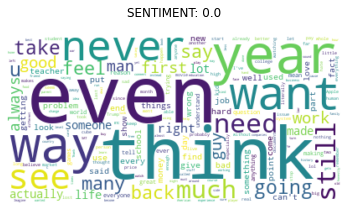

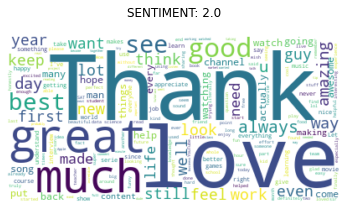

In [129]:
#Wordcloud for differrent sentiments i.e positive/neutral/negative
for c in data['SENTIMENT'].unique():
    t = data[data['SENTIMENT']==c]['COMMENT'].values.tolist()
    text = ' '.join(t)
    
    stop_words = ['video', 'people', \
                  'make', 'go', 'one',\
                  'like', 'could', 'would',\
                  'get','also',"i'm",'videos',\
                 'really','time','thing',\
                  'https','www','know','got',\
                  'que','de','lo','e','los',\
                  'mejores','game'] + list(stopwords.words('english'))
    wc_original = WordCloud(background_color="white",stopwords = stop_words).generate(text)

    plt.imshow(wc_original, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'SENTIMENT: {c}',pad=20)
    plt.show()
    